In [1]:
import numpy as np
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
from matplotlib import colors
import matplotlib.patches as patches
from salishsea_tools.nc_tools import scDataset
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [3]:
def get_varbs(dirname, fname, time_ind):
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    print('files')
    
    y, x = slice(1,-1,None), slice(1,-1,None)

    print(time_ind)
    
    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vovecrtz0 = dsW.variables['vovecrtz'][time_ind,:,y,x]
        print('W')
        vosaline0 = dsT.variables['vosaline'][time_ind,:,y,x]
        votemper0 = dsT.variables['vosaline'][time_ind,:,y,x]
        print('T')
        depthw = dsW.variables['depthw'][:]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        tmask = dsM.variables['tmask'][0,:,y,x]
        fmask = dsM.variables['fmask'][0,:,y,x]
        e2t0 = dsM.variables['e2t'][0, y, x]
        e1t0 = dsM.variables['e1t'][0, y, x]
        
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    votemper = np.ma.array(votemper0, mask=1 - tmask)
    
    e2t = np.cumsum(np.nanmean(e2t0, axis=1)) / 1000 # km
    e1t = np.cumsum(np.nanmean(e1t0, axis=0)) / 1000 # km
    
    print('w0 shape, tmask shape', vovecrtz0.shape, tmask.shape)
    print('e2, e1', e2t.shape, e1t.shape)
    
    idealf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
    ideal = idealf['Bathymetry'][y,x]
    
    return vovecrtz, vosaline, votemper, tmask, depthw, e1t, e2t, ideal

files
12
W
T
w0 shape, tmask shape (80, 172, 268) (80, 172, 268)
e2, e1 (172,) (268,)
files
24
W
T
w0 shape, tmask shape (80, 172, 268) (80, 172, 268)
e2, e1 (172,) (268,)
files
36
W
T
w0 shape, tmask shape (80, 172, 268) (80, 172, 268)
e2, e1 (172,) (268,)
files
48
W
T
w0 shape, tmask shape (80, 172, 268) (80, 172, 268)
e2, e1 (172,) (268,)


/home/imachuca/anaconda3/envs/gsw_new/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


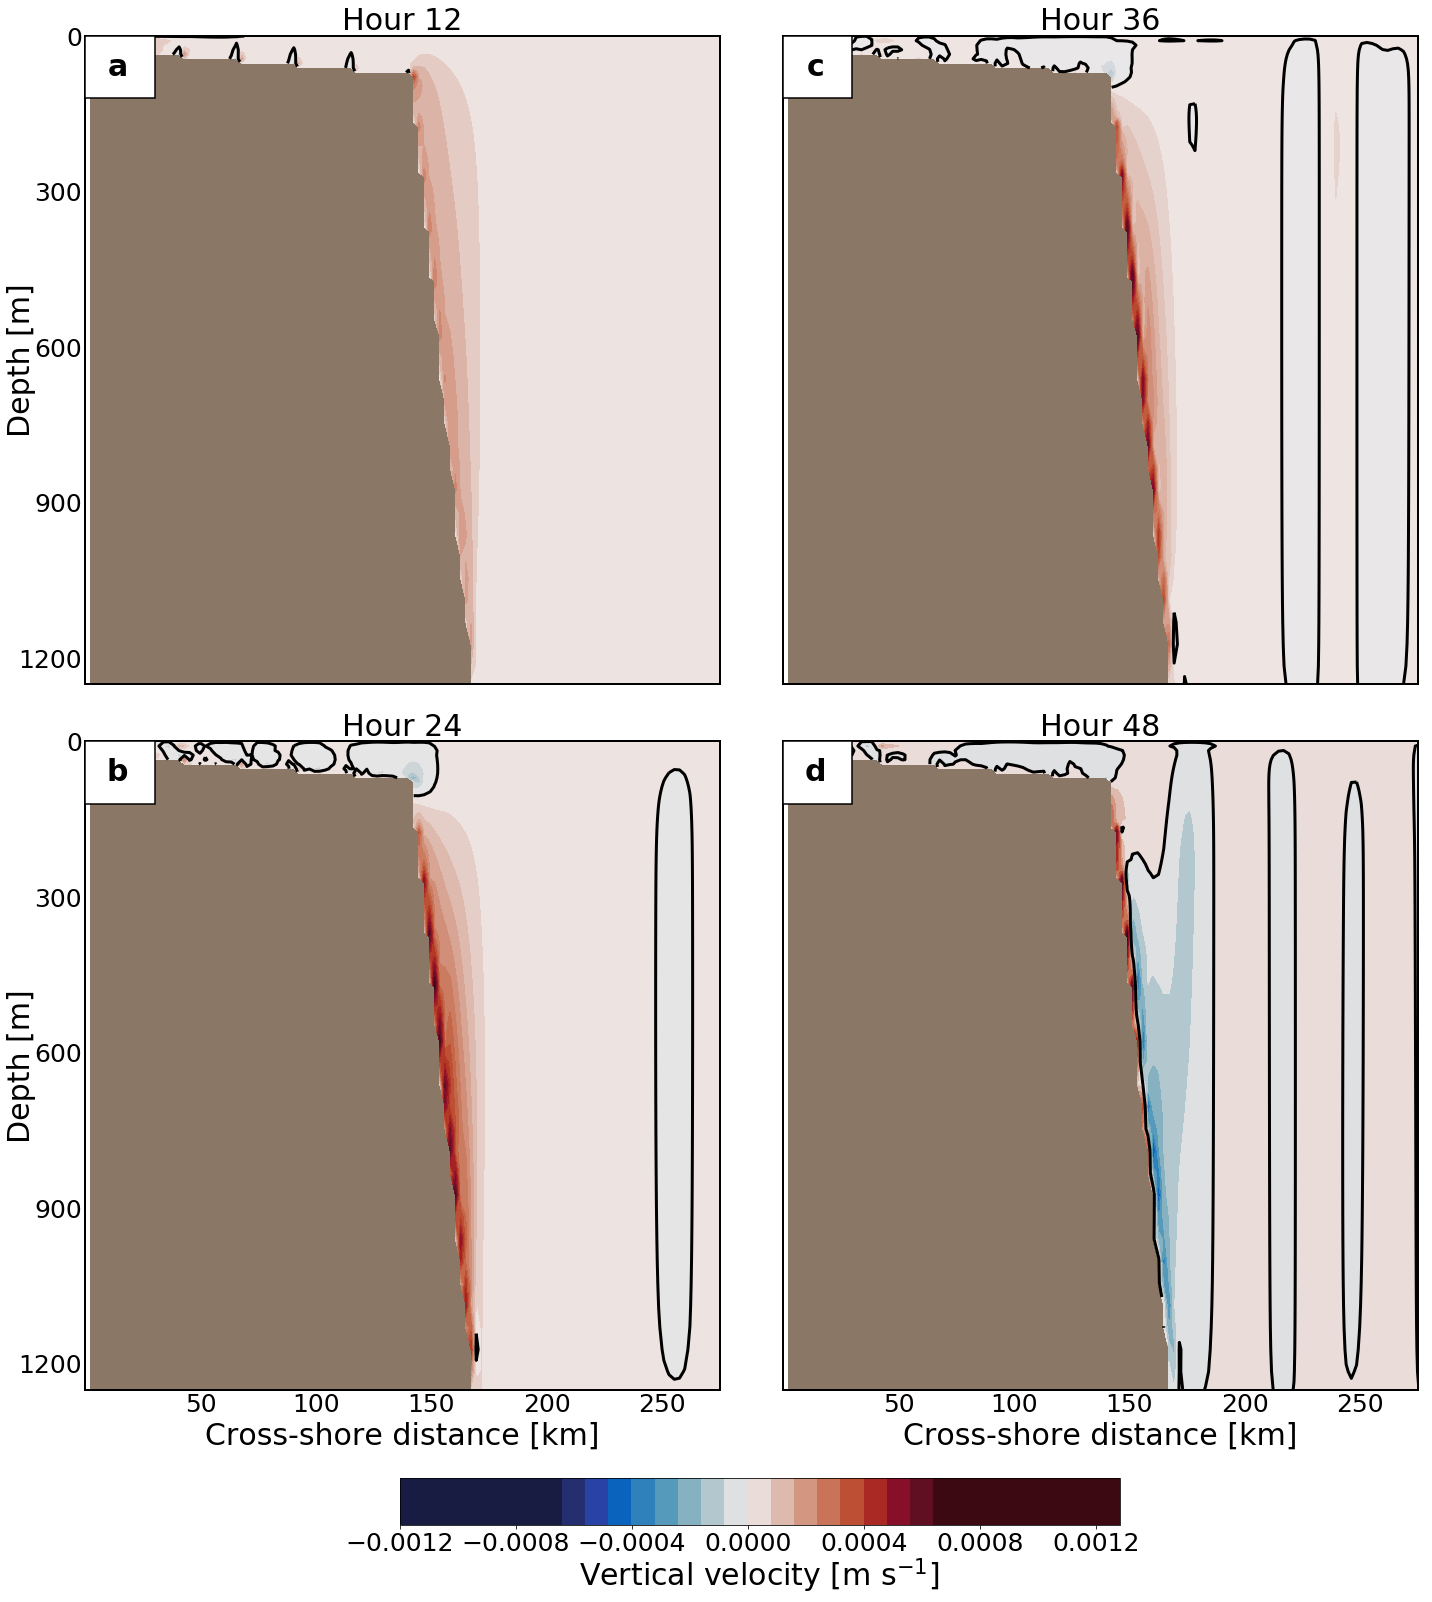

In [4]:
# figure
kind='ideal'
landc = '#8b7765'
fs_numb, fs_str = 25, 30
cmap = cmo.cm.balance
cmap.set_bad(landc)
norm = MidpointNormalize(midpoint=0)

if kind == 'ideal':
    x_left, y_bottom = 205.822543591543,24.85159075988878
    mid = 306
    ticklabs = np.arange(250,450,50)
elif kind == 'real':
    x_left, y_bottom = 296.29431501679437, 24.85159075988878
    mid = 400
    ticklabs = np.arange(350,550,50)
        
min_x, max_x = mid-150, mid+150

fig = plt.figure(figsize=(20, 22))
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1,1, 0.2])
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 1])
axoff = plt.subplot(gs[2, :]); axoff.axis('off')

# Mackenzie wave
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/'
fname = 'MCKNZ_1h_20170101_201701*'
meshmaskname = 'mesh_mask.nc'
x_ind = 161

for ax, time_ind, lab in zip([ax0, ax1, ax2, ax3], [12, 24, 36, 48], ['a','b','c','d']):

    vovecrtz, vosaline, votemper, tmask, depthw, e1t, e2t, ideal = get_varbs(dirname, fname, time_ind)

    # units and normalizing
    vovecrtz_plan = np.nanmean(vovecrtz, axis=0) # ms-1
    vovecrtz_cross = vovecrtz[:, :, x_ind] # ms-1
    tmask_cross = tmask[:, :, x_ind]

    vm = np.max([abs(np.nanmin(vovecrtz_cross)), abs(np.nanmax(vovecrtz_cross))])
    ticksw = np.arange(-1.2, 1.3, 0.4)/1000 #ax0 vmin,vmax & ax1 levels


    # Mackenzie wave
    colorsList = [landc, 'w']
    CustomCmap = matplotlib.colors.ListedColormap(colorsList)
    interval = (ticksw[1]-ticksw[0])*0.2
    levels = np.arange(ticksw[0], ticksw[-1]+interval, interval)
    p = ax.contourf(e2t, depthw, vovecrtz_cross, levels=levels, cmap=cmap, vmin=-1*vm, vmax=vm, zorder=2)
    ax.contour(e2t, depthw, vovecrtz_cross, levels=[0], linewidths=3, linestyles='-', colors='k', zorder=3)
    ax.pcolormesh(e2t, depthw, tmask_cross[1:,:], cmap = CustomCmap, zorder=1)
    ax.yaxis.set_ticks(np.arange(0, 1300, 300))
    ax.xaxis.set_ticks(np.arange(50, 300, 50))
    ax.add_patch(patches.Rectangle((0, 0), (30), (120), fc='w', ec='k', lw=1.5, alpha=1, zorder=4))
    ax.annotate(lab, xy=(14,60), fontsize=30, weight='bold', va='center', ha='center', zorder=5)
    ax.set_title('Hour '+str(time_ind), fontsize=fs_str)
#     ax.annotate('Hour '+str(time_ind), xy=(2, 1220), fontsize=fs_numb, weight='bold', color='k')
    
    ymax=275
    zmax=1250
    ax.set_ylim([zmax, 0])
    ax.set_xlim([0, ymax])


#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.1)
#     cbar = fig.colorbar(p, cax=cax, orientation='vertical', ticks=ticksw)
#     cbar.ax.tick_params(labelsize=fs_numb)
#     cbar.ax.get_yaxis().labelpad = 50
    

    
cbaxes = fig.add_axes([0.28, 0.05, 0.5, 0.03])
cbar = fig.colorbar(p, ax=ax1, cax=cbaxes, orientation='horizontal', ticks=ticksw)
cbar.ax.tick_params(labelsize=fs_numb)
cbar.ax.set_xlabel('Vertical velocity [m s$^{-1}$]', fontsize=fs_str, labelpad=0.2)
    
for ax in (ax1, ax3):
    ax.set_xlabel('Cross-shore distance [km]', fontsize=fs_str)
for ax in (ax0, ax1):
    ax.set_ylabel('Depth [m]', fontsize=fs_str, labelpad=-18)
for ax in (ax0, ax2):
    ax.xaxis.set_tick_params(labelbottom=False)
for ax in (ax2, ax3):
    ax.yaxis.set_tick_params(labelbottom=False)

for ax in (ax0, ax1, ax2, ax3):
    ax.tick_params(direction='in', length=4, color='k', labelsize=fs_numb)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

fig.patch.set_facecolor('white')
fig.tight_layout()
plt.subplots_adjust(top=0.99, wspace=0.1, hspace=0.12)

fig.savefig('./fig_wave_hourly_section.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())